Importing libraries for further usage

In [9]:
# removing warnings
import warnings
warnings.filterwarnings('ignore')

# computational needs
import networkx as nx
import pandas as pd

# scraping for data
import urllib.request
from bs4 import BeautifulSoup 

# plotting
from matplotlib import pyplot as plt

# local files
import roads

# others
from unidecode import unidecode
import random, json
import numpy as np, numpy.random

useful methods for later

In [10]:
# CONSTANTS
MAX_JOBS_REFUGEES = 0.7

In [11]:
def remove_duplicates(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def get_job_potential( each):
    """Given a city, give the number of jobs found there."""
    
    # get the url for each city
    URL = "https://tr.indeed.com/jobs?l="+unidecode(each)    
    
    # extract the html, the values from the search
    soup = BeautifulSoup(urllib.request.urlopen(URL).read(), 'html.parser')
    values = soup.find("div", id="JOB_TYPE_rbo")
    
    # find total jobs found in this city
    if values == None: # if no job was found, skip
        return 0
    count = 0
    for li in values.find_all("li"):
        found_jobs = li.find("span", attrs={'class':"rbCount"}).text
        count += int( found_jobs[1:-1])
    return count

def update_info():
    """information about the job market in a all cities"""

    info = {}
    for n in G.nodes:
        # each refugee working knows 10 job openings
        jobs_info = 10 * G.nodes[n]['jobs_to_refugees']/(G.nodes[n]['jobs']+1)
        if jobs_info < 1 and jobs_info > 0.5:
            info[n] = jobs_info
        elif jobs_info <=0.5:
            info[n] = 0.5
        else:
            info[n] = 1.0
    return info

## Read City and Road data

In [24]:
cities = pd.read_csv("geo_data/cities_turkey.csv")
cities

,Unnamed: 0,city,lat,lng,Area(km²),population,Labour,Unemployment,Employment
0,0,İstanbul,41.011046,28.957798,"5,196",14804116.0,52.2,11.2,46.4
1,1,Ankara,39.911652,32.840305,"24,521",3517182.0,49.5,10.2,44.5
2,2,İzmir,38.412726,27.138376,"12,012",2500603.0,55.9,15.4,47.3
3,3,Bursa,40.195593,29.060130,"10,422",1412701.0,51.4,6.6,48.0
4,4,Adana,37.001667,35.328889,"13,915",1248988.0,49.9,13.2,43.3
...,...,...,...,...,...,...,...,...,...
76,76,Aksaray,38.372550,34.025370,"7,570",152201.0,50.1,5.8,47.2
77,77,Şırnak,37.513930,42.454324,"7,152",52743.0,37.6,20.1,30.0
78,78,Afyonkarahisar,38.756667,30.543333,"14,314",146136.0,54.1,5.6,51.1
79,79,Mersin,36.800392,34.612812,"15,485",537842.0,50.7,12.4,44.4


### Put these cities in the map

In [26]:
# Put everything in a graph
G = nx.Graph()

# create each city
for city in list(cities['city']):
    
    # get number of jobs for this city
    job_potential = 100#get_job_potential( city)
    
    # find position of city in map
    city_properties = cities[cities['city'] == city].iloc[0]
    
    # add the city to the graph
    G.add_node( city_properties['city'], 
               pos =    ( city_properties[ 'lat'], city_properties[ 'lng']), 
               size= int( city_properties[ 'population']),
               area= int( city_properties[ 'Area(km²)'].replace(',','')),
               unem= int( city_properties[ 'Unemployment']),
               refugees=0, jobs_to_refugees=0,
               jobs=job_potential*100)

### Connect the cities

In [27]:
# put the edges connecting the cities

# if found city in road, but not in data, fix manually
for road in main_roads:
    # if any of the paths is not in the list, then mention it, fix it manually
    for each in road:
        if each not in list(cities['city']):
            print("City not found in list: ",each) # TODO: deal automatically
            
    # remind the cities that are present
    for i in range(len(road)-1):
        # add a connection between each two cities
        G.add_edge( road[i], road[i+1], weight=10)
        
# connect the cities not in the list with the closest city in the list
not_found = set( cities['city'])- set(sum(main_roads, []))

for each in not_found:
    city = cities[ cities['city'] == each].iloc[0]
    
    # order cities present in list by distance to this city
    found = cities[cities['city'].isin( all_cities)]
    found['distance'] = ((found['lat']-city['lat'])**2 + (found['lng']-city['lng'])**2)
    closest_city = found.sort_values('distance').iloc[1]['city'] # get the closest
    
    # add road connecting these cities
    G.add_edge( city['city'], closest_city, weight=10)

### Get the zone where the refugees enter, connect those cities

In [28]:
# suggest area from Adana to Van
max_lat = cities[cities['city'] ==  'Van']['lat'].iloc[0]
max_lng = cities[cities['city'] ==  'Van']['lng'].iloc[0]
min_lng = cities[cities['city'] =='Adana']['lng'].iloc[0]

# filter
syrian_zone = list(cities[ ( cities[ 'lng'] <= max_lng) & 
                           ( cities[ 'lng'] >= min_lng) & 
                           ( cities[ 'lat'] <= max_lat)]['city'])

# connect all cities close to Syria with the closest cities in this area
for each in syrian_zone:
    
    city = cities[ cities['city'] == each].iloc[0]
    
    # order cities present in list by distance to this city
    found = cities[cities['city'].isin( [n for n in syrian_zone if n != each])]
    found['distance'] = ((found['lat']-city['lat'])**2 + (found['lng']-city['lng'])**2)
    closest_cities = found.sort_values('distance') 
    
    # add road connecting these cities
    # keep the weight lower to suggest less people can move in between
    G.add_edge( city['city'], closest_cities.iloc[0]['city'], weight=100)

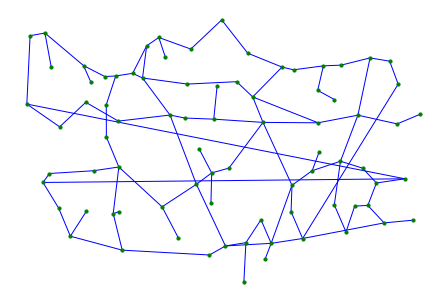

In [29]:
# Picture the map
pos = {city:(long, lat) for (city, (lat,long)) in nx.get_node_attributes(G, 'pos').items()}
nx.draw(G, pos, with_labels=False, node_size=10, node_color='g', edge_color='b')

### Start adding refugees depending on time

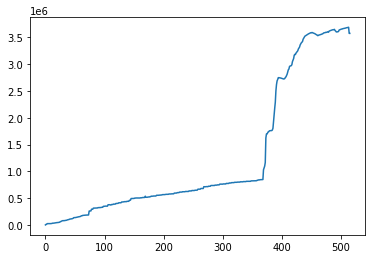

In [30]:
# define the zone where the refugees enter
# entrance dates for the refugees
entries = [0]+list( pd.read_json("syrian_refugees.json")['individuals'])
plt.plot( entries)

# working potential
# males that are able to work are in the age range 18-59, 50% of them need a job
# females that are able to work are in the age range 18-59, 10 % of them can deal with a job
# what is the percentage of people able to work?
with open( "distribution.json") as f:
    d = json.load(f)
work_percentage = (int(d['data'][0]['male_1859'])*0.5 
                   + int(d['data'][0]['female_1859'])*0.1)/int(d['data'][0]['individuals'])

### Getting a job
It is easier to get a job, once other refugees work in the same city (Job information). <br>
If the city is small, the chances decrease. <br>
If the number of refugees in the city is really high in proportion to the city's population, then your chances decrease. 

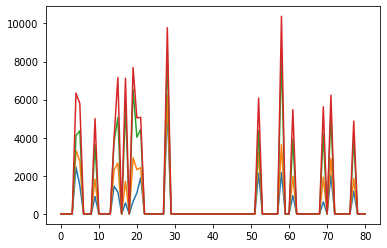

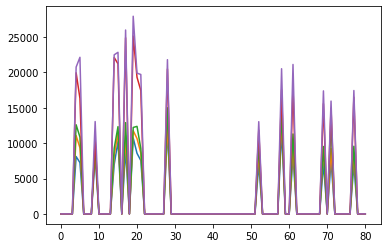

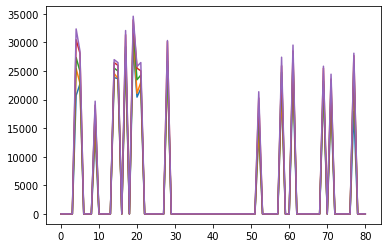

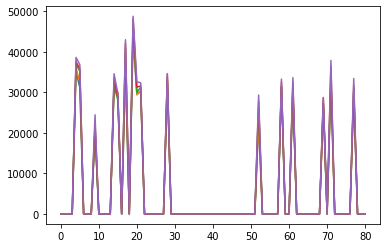

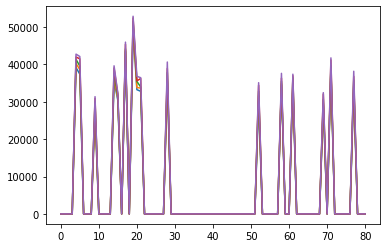

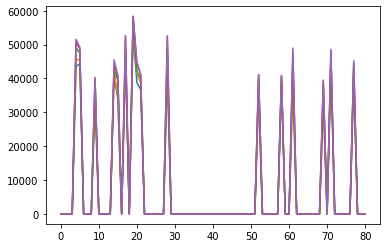

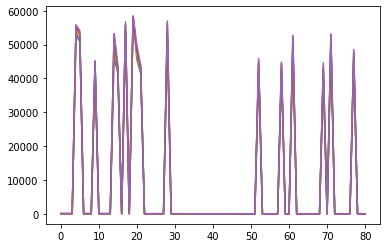

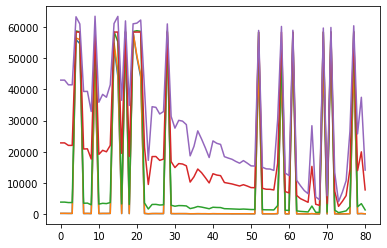

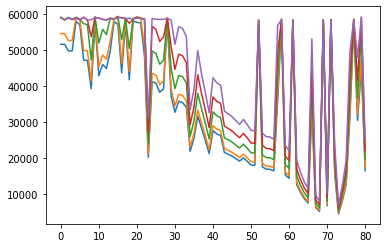

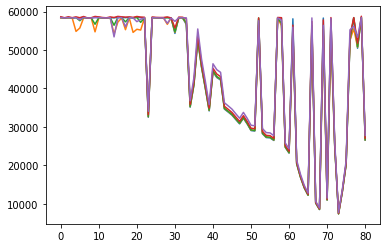

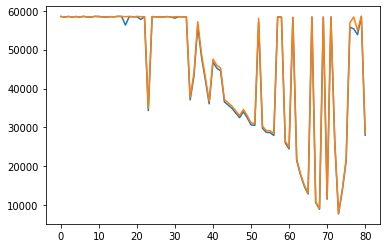

In [31]:
for run in range(1,len(entries)):
    
    # get the refugees difference from last run 
    diff = entries[run]-entries[run-1]
    distribute_refugees = np.random.dirichlet(\
                          np.ones( len( syrian_zone)), size=1)[0] * diff
    refugees = [int(n) for n in distribute_refugees]
    
    # put these people in the city
    for i in range(len(syrian_zone)):
        n = syrian_zone[i] # city close to syria
        G.nodes[ n]['refugees'] += refugees[i]
    
    # check other cities for jobs
    for city in all_cities:
                
        # get the jobs that are available for the refugees once in city
        job_vacancy =  G.nodes[ city]['jobs'] - G.nodes[ city]['jobs_to_refugees'] 
        potential_workers = int(work_percentage*G.nodes[city]['refugees']-\
                                G.nodes[city]['jobs_to_refugees'])                  
        if potential_workers > job_vacancy:
            G.nodes[city]['jobs_to_refugees'] += job_vacancy
        else:
            G.nodes[city]['jobs_to_refugees'] += potential_workers
            
        # give to the people not having a job the option to change city
        unemployed_refugees = int(G.nodes[city]['refugees']*work_percentage) \
                                - int(G.nodes[city]['jobs_to_refugees'])
        if unemployed_refugees <=0:
            continue
            
        # decision to change city: refugees, population/area, jobs, unemployment rate
        decision = []
        for each in all_cities:
            presence = G.nodes[each]['refugees']
            #density = G.nodes[each]['size'] * G.nodes[each]['unem']/100
            density = G.nodes[each]['refugees']/G.nodes[each]['size']
            jobs = G.nodes[each]['jobs']
            decision.append( (each,(jobs + presence*10), density))

        # sort by opportunities and density
        sort_opp = sorted(decision, key=lambda tup: tup[1])
        sort_den = sorted(decision, key=lambda tup: tup[2])
        sorted_city = {}
        for i,each in enumerate(sort_opp):
            sorted_city[ each[0]] = i
        for i,each in enumerate(sort_den):
            sorted_city[ each[0]] += len(sort_den) - i
        sorted_city = {k:v for k, v in sorted(sorted_city.items(), key=lambda item: item[1])}
       
        # found coefficient per person
        per_person = sum(sorted_city.values())/unemployed_refugees
        
        # find refugees to move to another city
        moved_refugees = 0
        for i in sorted_city:
            refugees_to_move = int( sorted_city[i]/(per_person*work_percentage))
            G.nodes[i]['refugees'] += refugees_to_move
            moved_refugees += refugees_to_move

        # remove the concentration
        G.nodes[city]['refugees'] -= moved_refugees
        
    if run%10 == 0:
        plt.figure(run/50)
        plt.plot([G.nodes[n]['refugees'] for n in G.nodes])

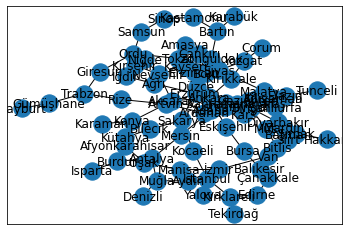

In [32]:
nx.draw_networkx(G)
plt.show()

In [33]:
for i in G.nodes:
    print("City:\t\t",i)
    print("Refugees: \t",G.nodes[i]['refugees'])
    print("Working: \t",G.nodes[i]['jobs_to_refugees'])
    print()

City:		 İstanbul
Refugees: 	 58396
Working: 	 10000

City:		 Ankara
Refugees: 	 58355
Working: 	 10000

City:		 İzmir
Refugees: 	 58390
Working: 	 10000

City:		 Bursa
Refugees: 	 58357
Working: 	 10000

City:		 Adana
Refugees: 	 54674
Working: 	 9374

City:		 Gaziantep
Refugees: 	 55475
Working: 	 9514

City:		 Konya
Refugees: 	 58392
Working: 	 10000

City:		 Antalya
Refugees: 	 58349
Working: 	 10000

City:		 Trabzon
Refugees: 	 58355
Working: 	 10000

City:		 Diyarbakır
Refugees: 	 56585
Working: 	 9700

City:		 Samsun
Refugees: 	 58382
Working: 	 10000

City:		 Kayseri
Refugees: 	 58360
Working: 	 10000

City:		 Eskişehir
Refugees: 	 58346
Working: 	 10000

City:		 Kocaeli
Refugees: 	 58381
Working: 	 10000

City:		 Malatya
Refugees: 	 55116
Working: 	 9452

City:		 Şanlıurfa
Refugees: 	 55890
Working: 	 9580

City:		 Erzurum
Refugees: 	 58383
Working: 	 10000

City:		 Kahramanmaraş
Refugees: 	 57754
Working: 	 9903

City:		 Denizli
Refugees: 	 58383
Working: 	 10000

City:		 Van
